##### Working with data
PyTorch has two primitives to work with data: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.

In [47]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The `torchvision.datasets` module contains Dataset objects for many real-world vision data like CIFAR, COCO. In this tutorial, we use the MNIST dataset. Every TorchVision Dataset includes two arguments: transform and target_transform to modify the samples and labels respectively.

In [ ]:


# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.



In [19]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X,y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


##### Creating Models
To define a neural network in PyTorch, we create a class that inherits from **nn.Module**. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

#Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


##### Optimizing the Model Parameters

In [ ]:
# To train a model, we need a loss function and an optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# In a single training loop, the model makes predictions on the training dataset (fed to it in batches),
# and backpropagates the prediction error to adjust the model’s parameters.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

# We also check the model’s performance against the test dataset to ensure it is learning.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# The training process is conducted over several iterations (epochs).
# During each epoch, the model learns parameters to make better predictions.
# We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298949 [   64/60000]
loss: 2.293535 [ 6464/60000]
loss: 2.306866 [12864/60000]
loss: 2.278746 [19264/60000]
loss: 2.290167 [25664/60000]
loss: 2.291656 [32064/60000]
loss: 2.282124 [38464/60000]
loss: 2.281824 [44864/60000]
loss: 2.271617 [51264/60000]
loss: 2.266452 [57664/60000]
Test Error: 
 Accuracy: 37.9%, Avg loss: 2.259343 

Epoch 2
-------------------------------
loss: 2.253267 [   64/60000]
loss: 2.246786 [ 6464/60000]
loss: 2.266094 [12864/60000]
loss: 2.218461 [19264/60000]
loss: 2.237500 [25664/60000]
loss: 2.242058 [32064/60000]
loss: 2.221059 [38464/60000]
loss: 2.239406 [44864/60000]
loss: 2.209929 [51264/60000]
loss: 2.197444 [57664/60000]
Test Error: 
 Accuracy: 59.8%, Avg loss: 2.193564 

Epoch 3
-------------------------------
loss: 2.187977 [   64/60000]
loss: 2.176320 [ 6464/60000]
loss: 2.204488 [12864/60000]
loss: 2.126700 [19264/60000]
loss: 2.154945 [25664/60000]
loss: 2.162343 [32064/60000]
loss: 2.123021 [38464/

##### Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [36]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


##### Loading Models
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [ ]:
##model.NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

This model can now be used to make predictions.

In [46]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "7", Actual: "7"


#### Playground 
This code samples are mine, by playing with the data:

##### Show predictions and actual numbers from the test data
We will use matplotlib

In [ ]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
model.eval()
num_images = 12 # Show the first 12 images

fig, axes = plt.subplots(3,4, figsize=(8,8))        # show the result in grid 3x4 images with 8,6 regions for each image

with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        x, y = test_data[i]                 # x: [1, 28, 28], y: label (0–9)

        # prepare the model
        x_device = x.unsqueeze(0).to(device)
        logits = model(x_device)
        pred_idx = logits.argmax(1).item()

        pred_label = classes[pred_idx]
        true_label = classes[y]

        # Visualisation
        ax.imshow(x.squeeze(), cmap="gray")
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
        ax.axis("off")
plt.tight_layout()
plt.show()


#### Show only one digit

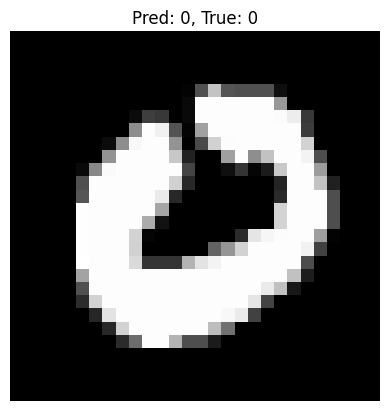

In [ ]:

idx = 0  # for example the first element from test_data
x, y = test_data[idx]

with torch.no_grad():
    x_device = x.unsqueeze(0).to(device)
    logits = model(x_device)
    pred_idx = logits.argmax(1).item()

plt.imshow(x.squeeze(), cmap="gray")
plt.title(f"Pred: {classes[pred_idx]}, True: {classes[y]}")
plt.axis("off")
plt.show()